### Define Data Loader
H = rows
W = cols

In [ ]:
# todo split into dataset and dataloader and batch_loader

# batch_loader 

In [1]:
# DEFINE THE DATASET AND THE DATALOADER
import torch
import numpy as np

"""
Note: when rewriting this code - keep everything in numpy array - only convert to torch or transfer to torch gpu 
in the actually training loop, only batches should be moved to GPU to save memory usage.
"""


# TODO Convert this into a dataset and let the pytorch loader to the magic
# TODO INHERIT FROM DATASET INSTEAD AND DEFINE LEN AND GET ITEM FUNCTIONS
class STResNetDataLoader:  # add test and train data and validation set
    def __init__(self, S, E, lc=3, lp=3, lq=3, c=1, p=24, q=168, shuffle=False, trn_tst_split=0.8, trn_val_split=0.8,
                 overlap_in_out=True, norm='none'):
        """
        Args:
            S: Total Sequence size -> (N,rows,cols)
            E: External Info -> (N, n_features)
            lc,lp,lq: number of closeness, period and trend frames respectively
            c,p,q: time step of closeness, period and trend frames respectively

            shuffle: if true shuffles the training batch after each epoch
            trn_tst_split: ratio between train and test data split
            trn_val_splt: ratio between train and val data split
            overlap_in_out: if false, make sure that none of the train/validation/test sets' input and output data overlaps
            norm: [minmax | meanstd | none]

        """
        # DATA
        self.S = S
        self.E = E

        # DATA FORMAT PARAMETERS
        self.lc = lc
        self.lp = lp
        self.lq = lq

        self.c = c
        self.p = p
        self.q = q

        # TRAIN/VAL/TEST DATA INDICES
        self.max_t = len(self.S)
        self.min_t = self.lq * self.q  # might not be the min in case p >> q

        self.max_t_val = int(
            np.floor((len(self.S) - self.min_t) * trn_tst_split) + self.min_t)  # max values for validation set
        self.max_t_trn = int(
            np.floor((self.max_t_val - self.min_t) * trn_val_split) + self.min_t)  # max values for train set

        self.trn_times = np.arange(self.min_t, self.max_t_trn, dtype=int)
        self.trn_val_times = np.arange(self.min_t, self.max_t_val, dtype=int)  # train and validation together

        if overlap_in_out:
            gap = 0
        else:
            gap = self.min_t

        self.val_times = np.arange(self.max_t_trn + gap, self.max_t_val, dtype=int)
        self.tst_times = np.arange(self.max_t_val + gap, self.max_t, dtype=int)

        # TRAIN MEAN,STD,MIN,MAX FOR SCALING
        trn_data = S[self.trn_times]
        self.trn_mean = trn_data.mean()
        self.trn_std = trn_data.std()
        self.trn_min = trn_data.min()
        self.trn_max = trn_data.max()

        # NORMALIZE THE DATA
        if norm == 'minmax':
            self.S = self.minmax_norm(S)

        if norm == 'meanstd':
            self.S = self.mean_std_norm(S)

        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.trn_times)

        self.current_t = 0

        # TODO: Add t_range so that we get a concept of time
        print('Total data: ', len(S))
        print('Usable data: ', len(self.tst_times) + len(self.trn_times) + len(self.val_times))
        print('Train data: ', len(self.trn_times))
        print('Validation data: ', len(self.val_times))
        print('Test data: ', len(self.tst_times))
        print()

    def get_train_data_length(self):
        return len(self.trn_times)

    def __call__(self, batch_size):
        """
        Returns a random batch from the training data
        return Dbc,Dbp,Dbq,Dbt,times
        """
        return self.get_train_batch(batch_size)

    def get_data(self, times):
        """
        returns data sequences given a set of Xt times
        return Dbc,Dbp,Dbq,Dbe,Dbt,times
        """
        Dbc = []  # batch of Xc (closeness)
        Dbp = []  # batch of Xp (period)
        Dbq = []  # batch of Xq (trend)
        Dbt = []  # batch of Xt (current time slot)
        Dbe = []  # batch of Et (external factors of current time slot)

        for t in times:
            Sc = self.S[t - self.c * self.lc:t:self.c]
            Sp = self.S[t - self.p * self.lp:t:self.p]
            Sq = self.S[t - self.q * self.lq:t:self.q]
            Dbc.append(Sc)
            Dbp.append(Sp)
            Dbq.append(Sq)

            Xt = self.S[t:t + 1]
            Dbt.append(Xt)
            # if self.E is not None:
            Et = self.E[t:t + 1]
            Dbe.append(Et)

        Dbc = np.stack(Dbc)
        Dbp = np.stack(Dbp)
        Dbq = np.stack(Dbq)
        Dbe = np.stack(Dbe)
        Dbt = np.stack(Dbt)

        return Dbc, Dbp, Dbq, Dbe, Dbt, times

        # if self.E != None:
        #     Dbe = np.stack(Dbe)
        #     return Dbc,Dbp,Dbq,Dbe,Dbt
        # else:
        #     return Dbc,Dbp,Dbq,Dbt

    def get_train_batch(self, batch_size):  # TODO fix offset
        """
        Returns a random batch from the train set
        format: Dbc,Dbp,Dbq,Dbe,Dbt,times

        """
        # times = np.random.choice(range(self.min_t,self.max_t_trn),size=batch_size,replace=False)
        times = self.trn_times[self.current_t:self.current_t + batch_size]
        if len(times) < 1:
            if self.shuffle:
                np.random.shuffle(self.trn_times)  # Shuffle after every epoch
            self.current_t = 0
            times = self.trn_times[self.current_t:self.current_t + batch_size]
        else:
            self.current_t = self.current_t + batch_size

        return self.get_data(times)

    def get_test_set(self):
        """
        returns all data in test set
        format: Dbc,Dbp,Dbq,Dbe,Dbt,times
        """
        #         times = np.arange(self.max_t_val,self.max_t)
        times = self.tst_times

        return self.get_data(times)

    def get_train_set(self):
        """
        returns all data in train set
        format: Dbc,Dbp,Dbq,Dbe,Dbt,times
        """
        #         times = np.arange(self.min_t,self.max_t_trn)
        times = self.trn_times

        return self.get_data(times)

    # TODO: Implement cross validation
    def get_validation_set(self):
        """
        returns all data in train set
        format: Dbc,Dbp,Dbq,Dbe,Dbt and times
        """
        #         times = np.arange(self.max_t_trn,self.max_t_val)
        times = self.val_times

        return self.get_data(times)

    def reset_current_t(self):
        self.current_t = 0

    def minmax_norm(self, data):
        #       return (data-self.trn_min)/(self.trn_max-self.trn_min)
        return (data - self.trn_min) / (self.trn_max - self.trn_min)

    def mean_std_norm(self, data):
        return (data - self.trn_mean) / self.trn_std

    def minmax_norm_r(self, data):
        """
        reverse minmax_norm transformation
        """
        #       return data*(self.trn_max-self.trn_min) + self.trn_min
        return data * (self.trn_max - self.trn_min) + self.trn_min

    def mean_std_norm_r(self, data):
        """
        reverse meanstd_norm transformation
        """
        return data * self.trn_std + self.trn_mean


### Load raw data

In [2]:
# drop weather fo now and just check what you can get
# or cap everything to the length of the weather
# or cap
from datasets.grid_dataset import GridDataGroup
from datasets.flat_dataset import FlatDataGroup
from utils.plots import im
import pandas as pd
from pprint import pprint
import numpy as np
from utils.configs import BaseConf
import matplotlib.pyplot as plt
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage,\
                                   TriangularMovingAverage, HistoricAverage
from utils.metrics import CellPlotter

In [3]:
# data_dim_str = "T24H-X850M-Y880M"
data_dim_str = "T1H-X1700M-Y1760M"

data_path = f"./data/processed/{data_dim_str}/"


conf_dict = {
    "seed": 3,
    "resume": False,
    "early_stopping": False,
    "use_cuda": False,
    "val_ratio": 0.1,
    "tst_ratio": 0.2,
    "sub_sample_train_set": 1,
    "sub_sample_validation_set": 1,
    "sub_sample_validation_set": 0,
    "flatten_grid": True,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 10,
    "batch_size": 64,
    "dropout": 0,
    "shuffle": False,
    "num_workers": 6,
    "seq_len": 0
}


conf = BaseConf(conf_dict=conf_dict)

data_group = GridDataGroup(data_path=data_path, conf=conf)

In [4]:
test_set = data_group.testing_set

In [7]:
from utils.mock_data import generate_mock_data

In [19]:
S = test_set.crimes[:,0]
E = test_set.time_vectors

# S: Total Sequence size -> (N,rows,cols)
# E: External Info -> (N, n_features)
n_feats = 10
N,H,W = 3000, 20, 20
S = np.ones((N,H,W))*np.arange(N).reshape((N,1,1))
E = np.ones((N,n_feats))*np.arange(N).reshape((N,1,1))

In [20]:
loader = STResNetDataLoader(S, E, lc=3, lp=3, lq=3, c=1, p=24, q=168, shuffle=False, trn_tst_split=0.8, trn_val_split=0.8,
                 overlap_in_out=True, norm='none')

Total data:  3000
Usable data:  2496
Train data:  1596
Validation data:  400
Test data:  500



In [38]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [42]:
from torch import nn, optim

In [70]:
import torch
import torch.nn as nn

"""
General notes on module:
========================
### STRes-Net (add link to paper)
* **Input Data Format:** (N,C,H,W) where C a.k.a the channels is the previous time steps leading up to t
* **Input Data Type:** Continuous value (number of crimes per cell)
* **Output Data Format:** (N,C,H,W) 
* **Output Data Type:** Continuous value (number of crimes per cell)
* **Loss Function:** RMSE
"""


class ResUnit(nn.Module):
    def __init__(self, n_channels=1):
        super(ResUnit, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.bn2 = nn.BatchNorm2d(n_channels)

    # using pytorch default weight inits (Xavier Init) we should probably use nn.init.kaiming_normal_
    #         self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.uniform_(-0.5, 0.5)
        self.conv2.bias.data.fill_(0)
        self.conv1.weight.data.uniform_(-0.5, 0.5)
        self.conv2.bias.data.fill_(0)

    def forward(self, x):
        o = self.bn1(x)
        o = self.relu(o)
        o = self.conv1(o)
        o = self.bn2(o)
        o = self.relu(o)
        o = self.conv2(o)
        o = x + o

        return o


class ResNet(nn.Module):
    def __init__(self, n_layers=1, in_channels=1, n_channels=1):
        """
        n_layers: number of ResUnits
        in_channels: number of channels at conv1 input 
        n_channels: number of channels at conv1 output and res-units inputs
        conv2 take n_channels and outputs 1 channel
        """
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.resUnits = nn.Sequential()
        for i in range(n_layers):
            self.resUnits.add_module(name='ResUnit' + str(i), module=ResUnit(n_channels))

        # self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.uniform_(-0.5, 0.5)
        self.conv2.bias.data.fill_(0)
        self.conv1.weight.data.uniform_(-0.5, 0.5)
        self.conv2.bias.data.fill_(0)

    def forward(self, x):
        o = self.conv1(x)
        o = self.resUnits(o)
        o = self.conv2(o)

        return o


class ExternalNet(nn.Module):  # need to add 
    def __init__(self, in_features, y_size, x_size):
        super(ExternalNet, self).__init__()

        self.y_size = y_size
        self.x_size = x_size
        self.out_features = y_size * x_size
        self.fc1 = nn.Linear(in_features, self.out_features)
        self.fc2 = nn.Linear(self.out_features, self.out_features)
        self.relu = nn.ReLU()

        # self.init_weights()

    def init_weights(self):
        self.fc1.weight.data.uniform_(-0.5, 0.5)
        self.fc1.bias.data.fill_(0)
        self.fc2.weight.data.uniform_(-0.5, 0.5)
        self.fc2.bias.data.fill_(0)

    def forward(self, a):
        Xext = self.fc2(self.relu(self.fc1(a)))
        return Xext.view(-1, 1, self.y_size, self.x_size)


class Fuse(nn.Module):  # fuse the 3 matrices with parametric matrices
    def __init__(self, y_size, x_size):
        super(Fuse, self).__init__()

        self.Wc = nn.parameter.Parameter(torch.zeros(y_size, x_size))
        self.Wp = nn.parameter.Parameter(torch.zeros(y_size, x_size))
        self.Wq = nn.parameter.Parameter(torch.zeros(y_size, x_size))

        # self.init_weights()

    def init_weights(self):
        self.Wc.data.uniform_(-0.5, 0.5)
        self.Wp.data.uniform_(-0.5, 0.5)
        self.Wq.data.uniform_(-0.5, 0.5)

    def forward(self, Xc, Xp, Xq):
        Xres = self.Wc * Xc + self.Wp * Xp + self.Wq * Xq
        return Xres


class STResNet(nn.Module):
    def __init__(self, n_layers, y_size, x_size, lc=1, lp=1, lq=1, n_channels=1, n_ext_features=10):
        """
        n_layers: number of layers
        y_size: grids.shape[-2]
        x_size: grids.shape[-1]
        ext_features: number of external features, dimensions of E
        """

        # TODO: check if pytorch has parallel modules like sequential
        # TODO: See if we can set parallel networks by a param: not just lc,lp,lq, but even more
        # TODO: Add option with no external data

        super(STResNet, self).__init__()
        self.resNetc = ResNet(n_layers, in_channels=lc, n_channels=n_channels)
        self.resNetp = ResNet(n_layers, in_channels=lp, n_channels=n_channels)
        self.resNetq = ResNet(n_layers, in_channels=lq, n_channels=n_channels)
        self.extNet = ExternalNet(in_features=n_ext_features, y_size=y_size, x_size=x_size)
        self.fuse = Fuse(y_size=y_size, x_size=x_size)

    def forward(self, Sc, Sp, Sq, Et=None):
        """
        Inputs:
        =======
        Sc, Sp , Sq: Sequence of grids - each grid as a channel
        Et: External features at time t

        Outputs:
        ========
        Xt_hat: Estimated crime grid at time t
        """
        # l indicates the output of the lth ResUnit
        Xc = self.resNetc(Sc)
        Xp = self.resNetp(Sp)
        Xq = self.resNetq(Sq)
        Xres = self.fuse(Xc, Xp, Xq)
        
       

        # sigmoid squeezes values between 0 and 1 that's, that's why the cum-sum wasn't working
        #         Last layer is sigmoid not tanh
        #         our values are all positive no real reason to use tan like the used in deep-st
        if Et is None:
            Xt_hat = torch.sigmoid(Xres)
        else: 
            Xext = self.extNet(Et)        
            Xt_hat = torch.sigmoid(Xres + Xext)

        return Xt_hat

In [71]:
class ExternalNet(nn.Module):  # need to add 
    def __init__(self, in_features, y_size, x_size):
        super(ExternalNet, self).__init__()

        self.y_size = y_size
        self.x_size = x_size
        self.out_features = y_size * x_size
        self.fc1 = nn.Linear(in_features, self.out_features)
        self.fc2 = nn.Linear(self.out_features, self.out_features)
        self.relu = nn.ReLU()

        # self.init_weights()

    def init_weights(self):
        self.fc1.weight.data.uniform_(-0.5, 0.5)
        self.fc1.bias.data.fill_(0)
        self.fc2.weight.data.uniform_(-0.5, 0.5)
        self.fc2.bias.data.fill_(0)

    def forward(self, a):
        Xext = self.fc2(self.relu(self.fc1(a)))
        return Xext.view(-1, 1, self.y_size, self.x_size)

In [72]:
n = 61
shape = in_features, y_size, x_size = 23, 13, 11
model = ExternalNet(*shape)
input_data = torch.Tensor(np.ones((n,in_features)))
output_data = model(input_data)
output_data.shape

torch.Size([61, 1, 13, 11])

### Training Loop

In [ ]:
# todo create batch loader that will load until it's run through all possibilities
# get data group separator - test, val, train data

Start Time: 2019-09-25 21:52:08.800555
Total data:  3000
Usable data:  2496
Train data:  2021
Validation data:  225
Test data:  250

Steps per epoch 63

Epoch: 0
Iteration: 0
Iteration: 50
Last Train Loss of Epoch: 0.5688894391059875
Last Validation Loss of Epoch: 0.7182467579841614
Current Best Validation Loss: 0.6890348792076111

Epoch: 1
Iteration: 100
Last Train Loss of Epoch: 0.5889267325401306
Last Validation Loss of Epoch: 0.71470046043396
Current Best Validation Loss: 0.6890348792076111

Epoch: 2
Iteration: 150
Last Train Loss of Epoch: 0.584270715713501
Last Validation Loss of Epoch: 0.71470046043396
Current Best Validation Loss: 0.6890348792076111

Epoch: 3
Iteration: 200
Iteration: 250
Last Train Loss of Epoch: 0.5695790648460388
Last Validation Loss of Epoch: 0.7129207253456116
Current Best Validation Loss: 0.6890348792076111

Epoch: 4
Iteration: 300
Last Train Loss of Epoch: 0.5808013677597046
Last Validation Loss of Epoch: 0.7129207253456116
Current Best Validation Loss: 

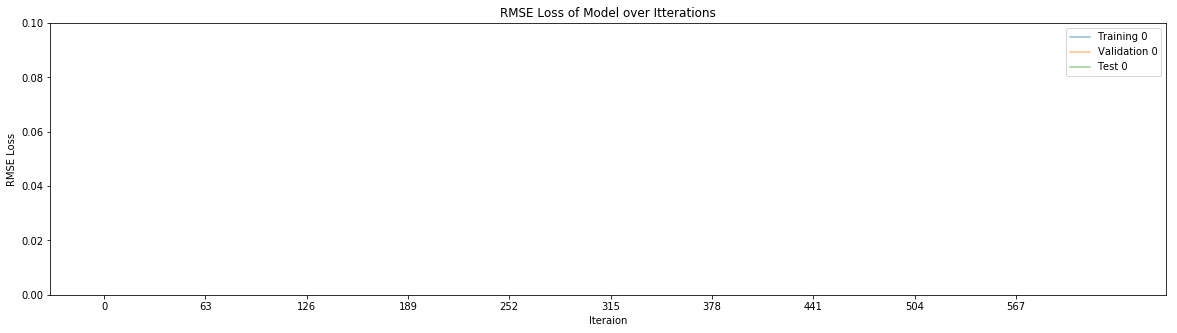

In [74]:
tst_collection = []
trn_collection = []
val_collection = []
best_model_val_collection = []
best_model_trn_collection = []

options = [0]
for option in options:
    print("========================================")
    print('Start Time:', pd.datetime.now())
    print("========================================")

#     datalimit = 5000
#     cap_grids = grids.copy()
#     cap_grids[cap_grids > cap] = cap

#     S = get_S(cap_grids[:datalimit], do_superres, do_cumsum).to(device)
#     E = get_E(t_range[:datalimit]).to(device)
    
    n_feats = 10
    N,H,W = 3000, 20, 20
    lc, lp, lq= 3, 3, 3
    c, p, q = 1, 24, 168
    n_layers = 2
    n_channels = 3
    
    S = np.ones((N,H,W))*np.arange(N).reshape((N,1,1))
    E = np.ones((N,n_feats))*np.arange(N).reshape((N,1))

    loader = STResNetDataLoader(S, E, lc=lc, lp=lp, lq=lq, c=c, p=p, q=q, shuffle=True, trn_tst_split=0.9, trn_val_split=0.9,
                        overlap_in_out=True, norm='minmax')
    loader.reset_current_t()

    torch.manual_seed(901)  # manual seed to test other params of the model and keep init weights constant

    lr = 0.005  # 1e-3 # make learn rate smaller if tends to average and epochs more
    model = STResNet(n_layers=n_layers, y_size=S.shape[-2], x_size=S.shape[-1], lc=lc, lp=lp, lq=lq,
                     n_channels=n_channels, n_ext_features=E.shape[-1])
    #   model.load_state_dict(best_model_val) # if you want to continue wherer you left off
    model.to(device)

    optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=0.000)  # Adam is used in literature 

    criterion = nn.MSELoss()  # for RMSE -> loss = torch.sqrt(criterion(*))

    n_epochs = 10
    batch_size = 32  # bigger the batch less noise / bad luck batches in the SGD 

    n_steps = loader.get_train_data_length() // batch_size
    print("Steps per epoch", n_steps)

    test_losses = []
    train_losses = []
    validation_losses = []
    min_val_loss = np.inf  # used for early stopping

    # TODO: Fix validation loss calculation
    # val batch size sub because of memory space on GPU cannot be 300 or we need to do val_loss in a loop
    valSc, valSp, valSq, valEt, valXt, valTimes = loader.get_validation_set()  # TODO: Implement cross validation
    valSc, valSp, valSq, valEt, valXt, valTimes = valSc[:batch_size], valSp[:batch_size], valSq[:batch_size], valEt[
                                                                                                              :batch_size], valXt[
                                                                                                                            :batch_size], valTimes[
                                                                                                                                          :batch_size]
    
    valSc, valSp, valSq, valEt, valXt = torch.Tensor(valSc), torch.Tensor(valSp), torch.Tensor(valSq), torch.Tensor(valEt), torch.Tensor(valXt)
    
    tstSc, tstSp, tstSq, tstEt, tstXt, tstTimes = loader.get_test_set()
    tstSc, tstSp, tstSq, tstEt, tstXt, tstTimes = tstSc[:batch_size], tstSp[:batch_size], tstSq[:batch_size], tstEt[
                                                                                                              :batch_size], tstXt[
                                                                                                                            :batch_size], tstTimes[
                                                                                                                                         :batch_size]
    
    tstSc, tstSp, tstSq, tstEt, tstXt = torch.Tensor(tstSc), torch.Tensor(tstSp), torch.Tensor(tstSq), torch.Tensor(tstEt), torch.Tensor(tstXt)
    
    itr = 0  # iteration
    val_loss_increased = False
    val_loss_step_limit = 3000  # used to check if validation loss is not increasing
    best_val_at_itr = 0

    for epoch in range(n_epochs):  # epoch is one iteration over the entire input data
        print("\nEpoch:", epoch)
        for step in range(n_steps):
            # Train Evaluation and Optimization Step
            model.train()
            optimizer.zero_grad()
            Sc, Sp, Sq, Et, Xt, times = loader.get_train_batch(batch_size)
            
            Sc, Sp, Sq, Et, Xt = torch.Tensor(Sc), torch.Tensor(Sp), torch.Tensor(Sq), torch.Tensor(Et), torch.Tensor(Xt)

            Xt_hat = model.forward(Sc, Sp, Sq, Et)

            trnLoss = torch.sqrt(criterion(Xt_hat, Xt))

            trnLoss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            train_losses.append(trnLoss.cpu().item())

            # Validation Evaluatiofn
            model.eval()
            valXt_hat = model.forward(valSc, valSp, valSq, valEt)

            valLoss = torch.sqrt(criterion(valXt_hat, valXt))

            validation_losses.append(valLoss.cpu().item())

            if validation_losses[-1] < min_val_loss:
                min_val_loss = validation_losses[-1]
                best_model_val = model.cpu().state_dict().copy()
                best_val_at_itr = itr
                model.to(device)

            # Test Evaluation  
            tstXt_hat = model.forward(tstSc, tstSp, tstSq, tstEt)

            tstLoss = torch.sqrt(criterion(tstXt_hat, tstXt))
            test_losses.append(tstLoss.cpu().item())

            if itr % 50 == 0:
                print("Iteration:", itr)

            # check if validation loss is increasing
            if (itr - best_val_at_itr) > val_loss_step_limit:
                print("========================================================")
                print("VAL LOSS NOT DECREASED IN LAST", str(itr - best_val_at_itr), "ITERATIONS")
                print("========================================================")
                val_loss_increased = True
                break

                # learnrate scheduler
            #       if itr == 100:
            #         optimizer.param_groups[0]['lr'] /= 2

            itr += 1

        print("Last Train Loss of Epoch:", train_losses[-1])
        print("Last Validation Loss of Epoch:", validation_losses[-1])
        print("Current Best Validation Loss:", min_val_loss)

        if val_loss_increased == True:
            break

    best_model_trn = model.cpu().state_dict().copy()
    model.to(device)
    tst_collection.append(np.array(test_losses))
    trn_collection.append(np.array(train_losses))
    val_collection.append(np.array(validation_losses))
    best_model_trn_collection.append(best_model_trn)
    best_model_val_collection.append(best_model_val)

    print("========================================")
    print('BEST VAL LOSS @ iteration:', str(best_val_at_itr))
    print('Stop Time:', pd.datetime.now())
    print("========================================\n\n")

plt.figure(figsize=(20, 5))
plt.title("RMSE Loss of Model over Itterations")
for i, _ in enumerate(trn_collection):
    plt.plot(trn_collection[i], label='Training ' + str(options[i]), alpha=0.5)
    plt.plot(val_collection[i], label='Validation ' + str(options[i]), alpha=0.5)
    plt.plot(tst_collection[i], label='Test ' + str(options[i]), alpha=0.5)

    plt.scatter(np.argmin(val_collection[i]), np.min(val_collection[i]))
plt.xticks(np.arange(0, itr, n_steps))
plt.xlabel("Iteraion")
plt.ylabel("RMSE Loss")
plt.legend()
plt.ylim(0, .1)
plt.show()

### Model Evaluation